## Let's start with a analysis of the dataset.
We split the information in different files and the data size was considerable, that's why we want to take a look more deep into the information

We DROP the next columns, with the following reasons:
*   Fwd PSH Flags = Just 1 or 0, but the most values are 0's
*   Bwd PSH Flags = All 0's
*   Fwd URG Flags = All 0's
*   Bwd URG Flags = All 0's

*   URG Flag Count = All 0's
*   CWR Flag Count = All 0's	
*   ECE Flag Count = All 0's

*   Fwd Bytes/Bulk Avg = All 0's
*   Fwd Packet/Bulk Avg	= All 0's
*   Fwd Bulk Rate Avg = All 0's


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, RepeatedKFold, cross_validate
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

import warnings
import time

import keras

TARGET_VARIABLE = 'Traffic Subtype'
DROP_COLUMNS = ['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp',
                'Fwd PSH Flags','Bwd PSH Flags','Fwd URG Flags','Bwd URG Flags',
                'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count',
                'Fwd Bytes/Bulk Avg', 'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg']

#TARGET_TO_DROP = {'Label': ['Traffic Type', 'Traffic Subtype'],
#                  'Traffic Type': ['Label', 'Traffic Subtype'],
#                  'Traffic Subtype': ['Label', 'Traffic Type']}

#Load extracted data
df = pd.read_csv("data.csv")

# Initial data overview
counts = df.groupby(['Label', 'Traffic Type', 'Traffic Subtype']).size().reset_index(name='Counts')
print(counts)


        Label           Traffic Type        Traffic Subtype   Counts
0      Benign                  Audio                  Audio      190
1      Benign             Background             Background       32
2      Benign                   Text                   Text      209
3      Benign                  Video             Video HTTP      376
4      Benign                  Video              Video RTP      349
5      Benign                  Video              Video UDP      145
6   Malicious             Bruteforce         Bruteforce DNS    22179
7   Malicious             Bruteforce         Bruteforce FTP     3485
8   Malicious             Bruteforce        Bruteforce HTTP      628
9   Malicious             Bruteforce         Bruteforce SSH     3967
10  Malicious             Bruteforce      Bruteforce Telnet     4913
11  Malicious                    DoS                DoS ACK   936307
12  Malicious                    DoS                DoS CWR   872523
13  Malicious                    D

In [37]:
# Drop collumns and timestamp
df = df.drop(columns=DROP_COLUMNS)

# Filter out duplicates within the same target
df = df.round(3)
df = df.drop_duplicates()
#df = df.drop(columns=TARGET_TO_DROP[TARGET_VARIABLE])

# Separate features and target
X = df.drop(TARGET_VARIABLE, axis=1)
y = df[TARGET_VARIABLE]




Split dataset in types


In [38]:
df_audio = df[df['Traffic Type'] == 'Audio']
df_video = df[df['Traffic Type'] == 'Video']
df_text = df[df['Traffic Type'] == 'Text']
df_Background = df[df['Traffic Type'] == 'Background']
df_Dos = df[df['Traffic Type'] == 'DoS']
df_Info_G = df[df['Traffic Type'] == 'Information Gathering']
df_Mirai = df[df['Traffic Type'] == 'Mirai']
df_Bruteforce = df[df['Traffic Type'] == 'Bruteforce']


Let's do this with 'Audio' Type as an example, we have 70 characteristics

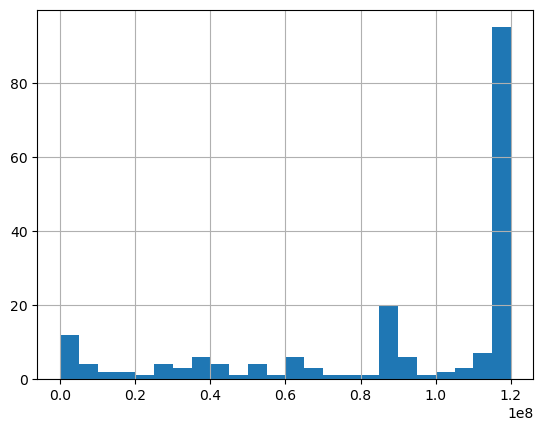

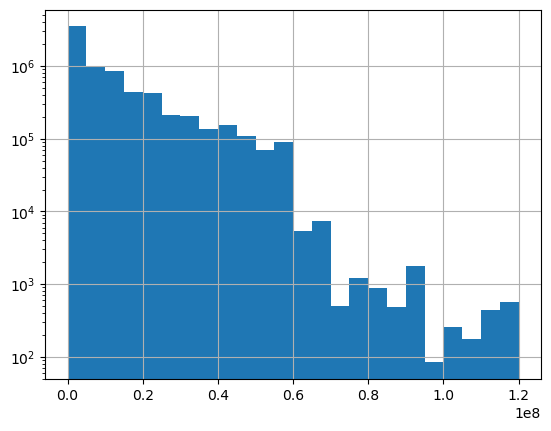

In [39]:
plt.figure()
plt.hist(df_audio["Flow Duration"],bins=24);
plt.grid()

plt.figure()
plt.hist(X["Flow Duration"],bins=24);
plt.yscale("log")
plt.grid()

In [40]:
# Encode target
le = LabelEncoder()
y = le.fit_transform(y)

# Compute train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42) 

In [41]:
# Identifying Numerical and Categorical columns
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.to_list()
numerical_cols.remove('Protocol')
categorical_cols = X_train.select_dtypes(include=[object]).columns.to_list()
categorical_cols.append('Protocol')

# Pipelines for Numerical and Categorical Data Transformations
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Column Transformer combining both pipelines
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ]
)

# Apply preprocessor to train and test data
preprocessor.fit(X_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [42]:
classifiers = [
    LogisticRegression(),
    RandomForestClassifier(512, max_depth=3, random_state=0),
    GradientBoostingClassifier(max_depth=3, random_state=0),
    KNeighborsClassifier(n_neighbors=1),
    KNeighborsClassifier(n_neighbors=3),
    #SVC(kernel="rbf", gamma=1),
    #SVC(kernel="linear"),
]

In [43]:
def warn(*args, **kwargs):
    pass
warnings.old_warn = warnings.warn
warnings.warn = warn
metrics = ["accuracy", "precision", "recall", "f1", "roc_auc"]

cv = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)
for clf in classifiers:
  cv_results = cross_validate(clf, X_train, y_train, cv=cv, n_jobs=-1, scoring=metrics)
  print(str(clf))
  print("Fit time", cv_results['fit_time'])
  print("Predict time", cv_results['score_time'])
  for m in metrics:
    print(m, cv_results[f'test_{m}'])
  print("------")

LogisticRegression()
Fit time [667.83724308 672.15237761 681.3868928 ]
Predict time [2.67472315 2.72918773 2.42602396]
accuracy [0.74377895 0.74124387 0.74760097]
precision [nan nan nan]
recall [nan nan nan]
f1 [nan nan nan]
roc_auc [nan nan nan]
------
RandomForestClassifier(max_depth=3, n_estimators=512, random_state=0)
Fit time [3991.56858563 4016.89233375 4019.2948072 ]
Predict time [444.40729547 451.2275815  450.41740274]
accuracy [0.61850271 0.61844851 0.61848797]
precision [nan nan nan]
recall [nan nan nan]
f1 [nan nan nan]
roc_auc [nan nan nan]
------


In [ ]:
cv = UpsampledRepeatedKFold(n_splits=5, random_state=42)

for clf in classifiers:
  cv_results = cross_validate(clf, X_train, y_train.values.ravel(), cv=cv, n_jobs=-1, scoring=metrics)
  print(str(clf))
  print("Fit time", cv_results['fit_time'])
  print("Predict time", cv_results['score_time'])
  for m in metrics:
    print(m, cv_results[f'test_{m}'])
  print("------")

In [ ]:
def upsampled_indices(y):
  # get index of major class (negative)
  idxs_class0 = np.argwhere(y == 0).ravel()
  # get index of minor class (positive)
  idxs_class1 = np.argwhere(y == 1).ravel()
  # get length of major class
  len_major = len(idxs_class0)
  # subsample of major class of size minor class
  idxs_class1_upsampled = np.random.choice(idxs_class1, size=len_major, replace=True)
  original_indx_upsampled = np.hstack((idxs_class1_upsampled, idxs_class0))
  np.random.shuffle(original_indx_upsampled)
  return original_indx_upsampled
new_indices = upsampled_indices(y_train.values.ravel())
upsampled_X_train = X_train.iloc[new_indices,:]
upsampled_y_train = y_train.iloc[new_indices,:]

## RANDOM FOREST

In [ ]:
%%time
clf = RandomForestClassifier(512, max_depth=7, random_state=0)
clf.fit(upsampled_X_train, upsampled_y_train)

NameError: name 'upsampled_X_train' is not defined